In [ ]:
import numpy as np
import sklearn as sk
from sklearn import ensemble
import matplotlib.pyplot as plt
from corner import corner

This notebook will guide you through the process of training a random forest on synthetic transmission spectra of exoplanets to retrieve their temperature; H$_2$O, HCN and NH$_3$ abundances; and cloud opacities. 

The methods and data are from Márquez-Neila et al., 2018.

### Random Forests

A Random Forest is an ensemble of decision/regression trees. Basic regression trees partition a data set into smaller groups and then fit a simple model (constant) for each subgroup. Unfortunately, a single tree model tends to be highly unstable and a poor predictor. A Random Forest solves this by aggregating the predictions of the individual trees.


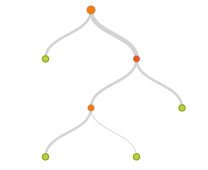

### Load the data

```Train``` contains the training set of 80,000 synthetic spectra.

```Test``` contains 20,000 synthetic spectra to evaluate the random forest once trained.

```WASP12b``` contains the HST/WFC3 spectrum of WASP-12b, taken from Kreidberg et al., 2015.

In [ ]:
Train   = np.load('../Data/Exoplanet_Retrieval_Problem/training.npy')
Test    = np.load('../Data/Exoplanet_Retrieval_Problem/testing.npy')
WASP12b = np.loadtxt('../Data/Exoplanet_Retrieval_Problem/WASP-12b_Kreidberg2015.dat')*100  # Factor 100 to convert it to %

### Define the metadata of the datasets.

There are 13 features, which are the 13 wavelength bins in the spectra.

The number of targets, or parameters, is 5. 

In [ ]:
num_features = 13
num_targets  = 5
names        = ['T', r'H$_2$O', 'HCN', r'NH$_3$', r'$\kappa$']

### Split the training and testing datasets into features and targets

In [ ]:
X_train = Train[:, :num_features]
Y_train = Train[:, num_features:]

X_test = Test[:, :num_features]
Y_test = Test[:, num_features:]

### Create the Random Forest and train it with the training data set.

```n_estimators``` is the number of trees to train.

```criterion``` defines the loss function, can be mse or mae,

```n_jobs``` defines the number of processors to use, setting it to -1 will use the maximum available

```max_features``` defines the subset of features (selected randomly) that the trees will look at to make the split

```min_impurity_decrease``` is the minimum reduction in variance required for a branch to split. 

In [ ]:
N_trees = 100

model = sk.ensemble.RandomForestRegressor(n_estimators=N_trees, criterion='mse', n_jobs=-1, 
                                          max_features=4, min_impurity_decrease=0.01)

model.fit(X_train, Y_train)

### Evaluate the Random Forest

Make predictions on the test dataset and plot them against the true values.

In [ ]:
pred = model.predict(X_test)

R2 = [sk.metrics.r2_score(Y_test[:,i], pred[:,i]) for i in range(len(Y_test[0]))]


fig, axs = plt.subplots( 2, 3, figsize=(18,12) )

c=0
for i in range(2):
    for j in range(3):
        if c==num_targets:
            break
            
        axs[i,j].scatter( Y_test[:,c], pred[:,c], alpha=.03, label = r'$R^2 = $' + str( round(R2[c], 2) ) )
        axs[i,j].plot( [-13,3000], [-13,3000], 'r--' )
        
        axs[i,j].set_xlim( [min(Y_test[:,c]), max(Y_test[:,c])] )
        axs[i,j].set_ylim( [min(Y_test[:,c]), max(Y_test[:,c])] )
        
        axs[i,j].set_xlabel('True ' + names[c])
        axs[i,j].set_ylabel('Predicted ' + names[c])
        axs[i,j].grid(True)
        axs[i,j].legend()
        c+=1

axs[1,2].remove()
plt.suptitle( r'$R^2=$ ' + str( round( np.mean(R2), 2 ) ) )
plt.show()

### WASP-12b retrieval

Draw 100 samples of WASP-12b's spectrum scattered according to the errorbars of the observation.

In [ ]:
N_samples = 1000

trans = WASP12b[:,1].reshape(1,13)
noise = WASP12b[:,2].reshape(1,13)

trans = np.repeat(trans, N_samples, axis=0)
noise = np.repeat(noise, N_samples, axis=0)

samples = trans + np.random.normal(scale=noise)

plt.errorbar(0.01*WASP12b[:,0], trans[0], yerr=noise[0], fmt='k.-', capsize=3)
plt.xlabel(r'$\lambda$ ($\mu m$)')
plt.ylabel(r'$(R_P/R_S)^2$ (%)')
plt.show()

Get the individual predictions of the trees in the Random Forest

In [ ]:
per_tree_pred = np.array([tree.predict(samples) for tree in model.estimators_])

per_tree_flat = per_tree_pred.reshape(N_trees*N_samples, num_targets)

Plot the individual predictions of the trees in a corner plot. This shows us the posterior probability distribution of the parameters. Blue lines from Nested Sampling retrieval in Márquez-Neila et al (2018).

In [ ]:
CORNER_KWARGS = dict(
    smooth=.75,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    truths=[1105, -3, -8.5, -8.4, -2.8],
    range=[(500,3000),(-13,0),(-13,0),(-13,0),(-13,3)]
)

fig=corner(per_tree_flat, labels=names, **CORNER_KWARGS)